In [248]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [249]:
csv_file = './cumulative.csv'
df = pd.read_csv(csv_file)

**Data Overview**

In [250]:
print(df.shape)
print(df.columns)
print(df.head())
print(df.info())
print(df.describe())
print(df.isna().sum())
print(df.nunique())

(9564, 50)
Index(['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
       'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
       'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth',
       'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol',
       'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')
   rowid     kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0 

**Data Overview Inference:**

* Data has many irrelevant columns for modelling.
* Data has non-unique and missing values.
* Design a model to predict koi_disposition status : CONFIRMED or FALSE POSITIVE (ignore Candidate/unsure status)

**Goals:**

* Drop columns with too many missing values (thresold = 50% )
* Drop columns which are irrelevant for modelling eg: rowid, kepid, kepoi_name etc
* Fill remanining null data with their mean




In [251]:
from sklearn.impute import SimpleImputer

drop_cols = ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_teq_err1', 'koi_teq_err2', 'koi_tce_delivname']
df = df.drop(columns=drop_cols, errors='ignore')
df['koi_disposition'] = df['koi_disposition'].fillna(df['koi_disposition'].mode()[0])
df = df[df['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])]
threshold = 0.5 * len(df)
df = df.dropna(thresh=threshold, axis=1)

# imputer with strategy: mean
imputer_mean = SimpleImputer(strategy='mean')
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = imputer_mean.fit_transform(df[numeric_cols])
df['koi_disposition'] = df['koi_disposition'].map({'CONFIRMED': 1, 'FALSE POSITIVE': 0})

print(df.shape)
print(df.isna().sum())


(7316, 42)
koi_disposition      0
koi_score            0
koi_fpflag_nt        0
koi_fpflag_ss        0
koi_fpflag_co        0
koi_fpflag_ec        0
koi_period           0
koi_period_err1      0
koi_period_err2      0
koi_time0bk          0
koi_time0bk_err1     0
koi_time0bk_err2     0
koi_impact           0
koi_impact_err1      0
koi_impact_err2      0
koi_duration         0
koi_duration_err1    0
koi_duration_err2    0
koi_depth            0
koi_depth_err1       0
koi_depth_err2       0
koi_prad             0
koi_prad_err1        0
koi_prad_err2        0
koi_teq              0
koi_insol            0
koi_insol_err1       0
koi_insol_err2       0
koi_model_snr        0
koi_tce_plnt_num     0
koi_steff            0
koi_steff_err1       0
koi_steff_err2       0
koi_slogg            0
koi_slogg_err1       0
koi_slogg_err2       0
koi_srad             0
koi_srad_err1        0
koi_srad_err2        0
ra                   0
dec                  0
koi_kepmag           0
dtype: int64


###**Visuals and Graphs**

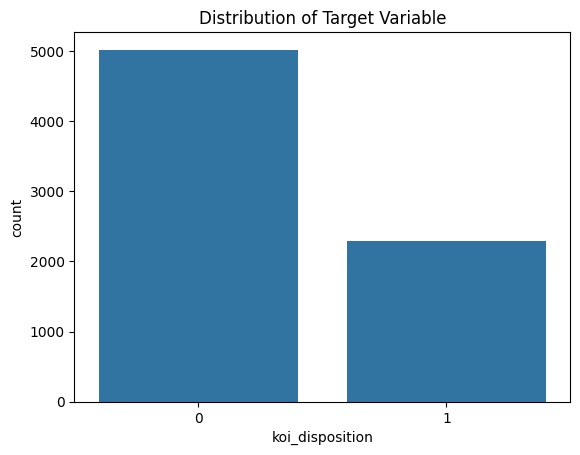

In [252]:
sns.countplot(data=df, x='koi_disposition',)
plt.title('Distribution of Target Variable')
plt.show()

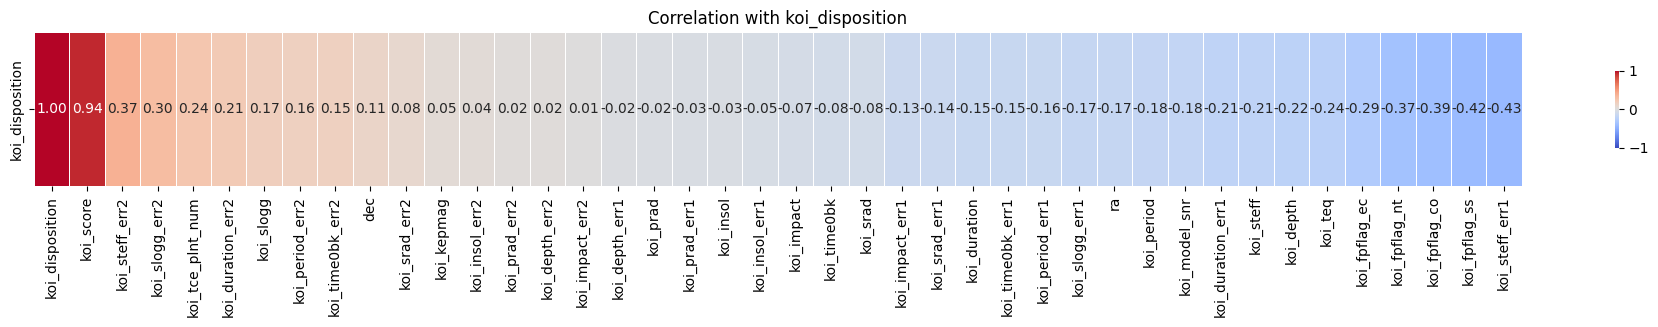

In [253]:
def plot_correlation_gradient(df, target_column='koi_disposition'):
  """
  Plots a heatmap showing the correlation of each feature in the DataFrame with a specified target column.

  Parameters:
  - df (pd.DataFrame): The DataFrame containing the data to analyze.
  - target_column (str): The name of the column to use as the target for correlation. Default is 'koi_disposition'.

  Description:
  This function computes the correlation matrix of the given DataFrame and extracts the correlation of each feature
  with the specified target column. It then plots a heatmap where the rows represent the features and the column
  represents the target column, displaying the correlation values.

  """
  corr_matrix = df.corr()
  target_corr = corr_matrix[[target_column]].sort_values(by=target_column, ascending=False)
  corr_matrix_subset = target_corr.T
  plt.figure(figsize=(24, 2))
  sns.heatmap(corr_matrix_subset, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=0.5, cbar_kws={'shrink': .5})
  plt.title(f'Correlation with {target_column}')
  plt.show()

plot_correlation_gradient(df)


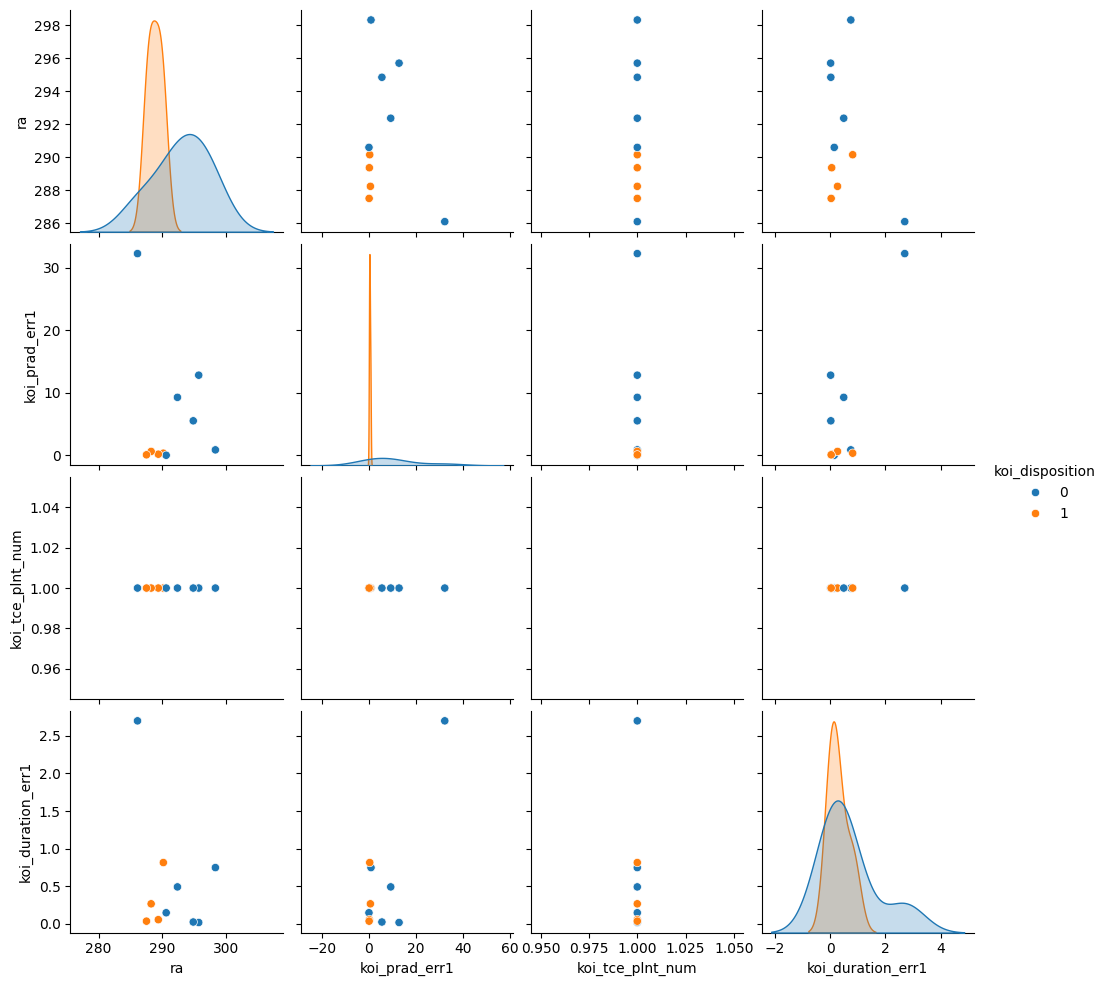

In [254]:
def slow_pairplot(df, hue="koi_disposition", max_features=4, sample_size=10):
  """
  Creates a pairplot of the DataFrame, focusing on a subset of features and using a sample of the data for performance improvement.

  Parameters:
  - df (pd.DataFrame): The DataFrame containing the data to plot.
  - hue (str): The name of the column to use for color-coding the plot. Default is koi_disposition.
  - max_features (int): The maximum number of features to include in the pairplot. Default is 4. Randomly selected from dataframe.
  - sample_size (int): The number of samples to use for the pairplot. Default is 1000. If the DataFrame has more rows, a random sample of this size will be used.

  Description:
  This function generates a pairplot to visualize the pairwise relationships between numeric features in the DataFrame.
  It limits the number of features plotted to manage computational load and enhance performance. Additionally, it down-samples
  the data if the DataFrame is too large to make the plot generation faster and more responsive.

  Note:
  Ensure that the `hue` column exists in the DataFrame before calling this function.
  """

  if hue not in df.columns:
      raise ValueError(f"The hue column '{hue}' does not exist in the DataFrame.")

  numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
  if len(numeric_cols) > max_features:
      selected_features = np.random.choice(numeric_cols, size=max_features, replace=False)
  else:
      selected_features = numeric_cols
  df_plot = df[list(selected_features) + [hue]]
  if len(df_plot) > sample_size:
      df_plot = df_plot.sample(n=sample_size)
  sns.pairplot(df_plot, hue=hue)
  plt.show()


slow_pairplot(df)

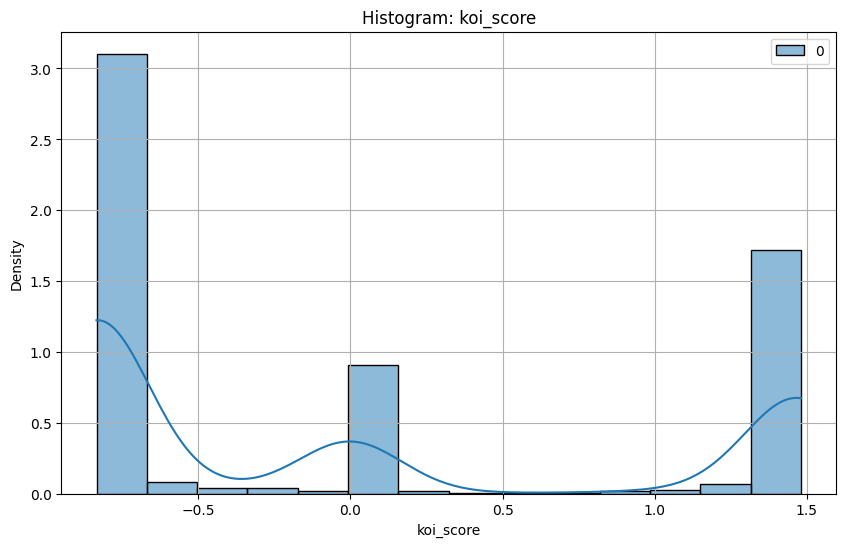

In [255]:
from sklearn.preprocessing import StandardScaler
def histplot_(df, column):
    scaler = StandardScaler()
    standardized_values = scaler.fit_transform(df[[column]])
    plt.figure(figsize=(10, 6))
    sns.histplot(standardized_values, kde=True, stat='density', color='skyblue')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.title(f'Histogram: {column}')
    plt.grid(True)
    plt.show()


histplot_(df, 'koi_score')

**Data Overview Inference:**

* Data has many irrelevant columns for modelling.
* Data has non-unique and missing values.
* Design a model to predict koi_disposition status : CONFIRMED or FALSE POSITIVE (ignore Candidate/unsure status)

**Goals:**

* Drop columns with too many missing values (thresold = 50% )
* Drop columns which are irrelevant for modelling eg: rowid, kepid, kepoi_name etc
* Fill remanining null data with their mean

In [256]:
# Cleaning Data
import pandas as pd
from sklearn.impute import SimpleImputer

file_path = '/content/drive/MyDrive/CSV Models/cumulative.csv'
df = pd.read_csv(file_path)

drop_cols = ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_teq_err1', 'koi_teq_err2', 'koi_tce_delivname']
df = df.drop(columns=drop_cols, errors='ignore')
df['koi_disposition'] = df['koi_disposition'].fillna(df['koi_disposition'].mode()[0])
df = df[df['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])]
threshold = 0.5 * len(df)
df = df.dropna(thresh=threshold, axis=1)

# imputer with strategy: mean
imputer_mean = SimpleImputer(strategy='mean')
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = imputer_mean.fit_transform(df[numeric_cols])
df['koi_disposition'] = df['koi_disposition'].map({'CONFIRMED': 1, 'FALSE POSITIVE': 0})

print(df.shape)
print(df.isna().sum())
df.head()


(7316, 42)
koi_disposition      0
koi_score            0
koi_fpflag_nt        0
koi_fpflag_ss        0
koi_fpflag_co        0
koi_fpflag_ec        0
koi_period           0
koi_period_err1      0
koi_period_err2      0
koi_time0bk          0
koi_time0bk_err1     0
koi_time0bk_err2     0
koi_impact           0
koi_impact_err1      0
koi_impact_err2      0
koi_duration         0
koi_duration_err1    0
koi_duration_err2    0
koi_depth            0
koi_depth_err1       0
koi_depth_err2       0
koi_prad             0
koi_prad_err1        0
koi_prad_err2        0
koi_teq              0
koi_insol            0
koi_insol_err1       0
koi_insol_err2       0
koi_model_snr        0
koi_tce_plnt_num     0
koi_steff            0
koi_steff_err1       0
koi_steff_err2       0
koi_slogg            0
koi_slogg_err1       0
koi_slogg_err2       0
koi_srad             0
koi_srad_err1        0
koi_srad_err2        0
ra                   0
dec                  0
koi_kepmag           0
dtype: int64


,koi_disposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,1.000,0.0,0.0,0.0,0.0,9.488036,2.775000e-05,-2.775000e-05,170.538750,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,1,0.969,0.0,0.0,0.0,0.0,54.418383,2.479000e-04,-2.479000e-04,162.513840,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,0,0.000,0.0,1.0,0.0,0.0,19.899140,1.494000e-05,-1.494000e-05,175.850252,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,0,0.000,0.0,1.0,0.0,0.0,1.736952,2.630000e-07,-2.630000e-07,170.307565,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,1,1.000,0.0,0.0,0.0,0.0,2.525592,3.761000e-06,-3.761000e-06,171.595550,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


###**Model Fitting**

Algorithm: Logistic Regression

Algorithm: Logistic Regression
Accuracy: 0.9913439635535307
Precision: 0.9925373134328358
Recall: 0.979381443298969
F1 Score: 0.9859154929577464


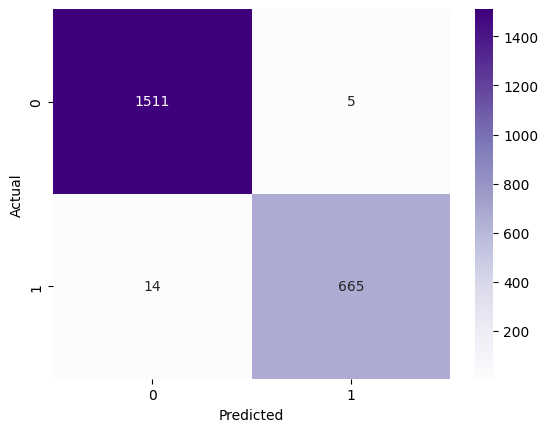

In [257]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

X = df.drop('koi_disposition', axis=1)
y = df['koi_disposition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

linear_model = LogisticRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

algorithm = "Logistic Regression"
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Algorithm: {algorithm}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Algorithm: Naive Bayes Classifier

Algorithm: Naive Bayes Classifier
Accuracy: 0.9558086560364465
Precision: 0.8873994638069705
Recall: 0.9807407407407407
F1 Score: 0.9317382125263899


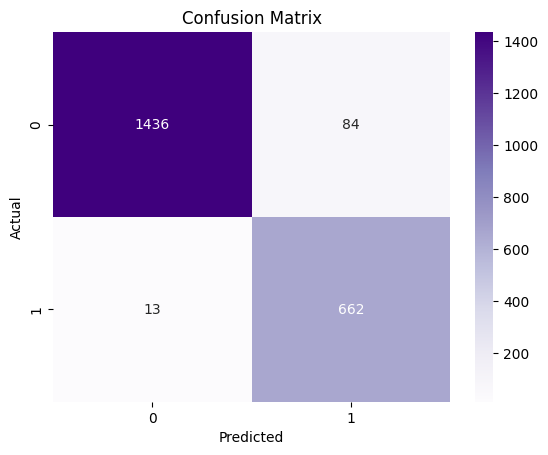

In [258]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X = df.drop('koi_disposition', axis=1)
y = df['koi_disposition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

algorithm = "Naive Bayes Classifier"
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Algorithm: {algorithm}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Algorithm: Random Forest Classifier

Algorithm: Random Forest Classifier
Accuracy: 0.9917995444191344
Precision: 1.0
Recall: 0.9733333333333334
F1 Score: 0.9864864864864865


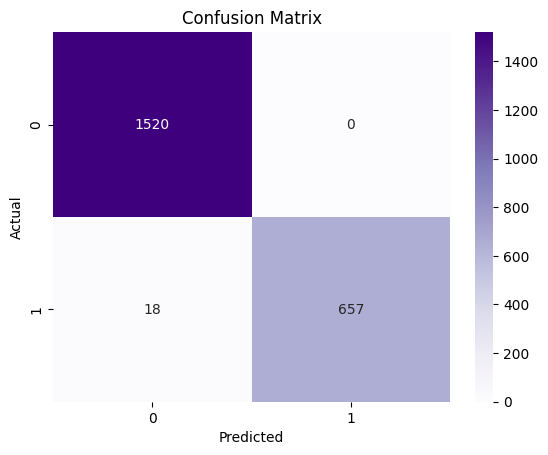

In [259]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

algorithm = "Random Forest Classifier"
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Algorithm: {algorithm}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Algorithm: Support Vector Machine

Algorithm: Support Vector Machine
Accuracy: 0.9908883826879271
Precision: 0.9954614220877458
Recall: 0.9748148148148148
F1 Score: 0.9850299401197604


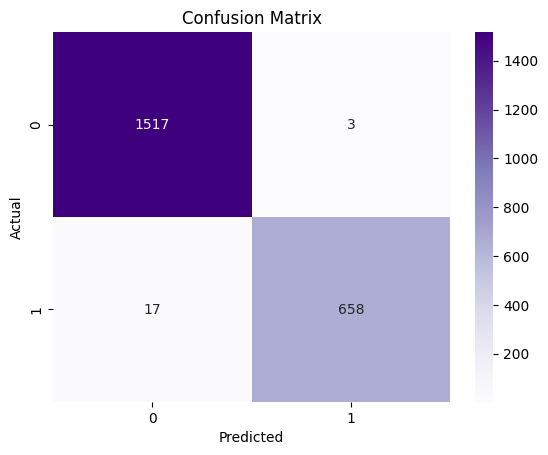

In [260]:
from sklearn.svm import SVC

svc_model = SVC(kernel='linear')
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)

algorithm = "Support Vector Machine"
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Algorithm: {algorithm}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
